# Problem Statement

**To build a predictive model, which could help cab-aggregators in predicting the '*surge_pricing_type*' pro-actively. This would in turn help them in matching the right cabs with the right customers quickly and efficiently.**

# Data Analysis

## Understanding data

In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from scipy import stats
from sklearn import preprocessing,model_selection

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,classification_report

In [2]:
#reading data
train = pd.read_csv("../input/train.csv")
test =  pd.read_csv("../input/test.csv")
print(train.shape,test.shape)

(131662, 14) (87395, 13)


In [3]:
#combining data for preprocessing
comb = train.append(test)
comb.shape

(219057, 14)

In [4]:
#getting information about datatypes and null values
comb.info()
print(comb.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219057 entries, 0 to 87394
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Trip_ID                      219057 non-null  object 
 1   Trip_Distance                219057 non-null  float64
 2   Type_of_Cab                  185689 non-null  object 
 3   Customer_Since_Months        209171 non-null  float64
 4   Life_Style_Index             185537 non-null  float64
 5   Confidence_Life_Style_Index  185537 non-null  object 
 6   Destination_Type             219057 non-null  object 
 7   Customer_Rating              219057 non-null  float64
 8   Cancellation_Last_1Month     219057 non-null  int64  
 9   Var1                         101238 non-null  float64
 10  Var2                         219057 non-null  int64  
 11  Var3                         219057 non-null  int64  
 12  Gender                       219057 non-null  object 
 13  

In [5]:
#Converting categorical variables to type category
cat_col = ['Type_of_Cab','Confidence_Life_Style_Index','Destination_Type','Gender','Surge_Pricing_Type']
comb[cat_col]= comb[cat_col].astype('category')

In [6]:
comb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219057 entries, 0 to 87394
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   Trip_ID                      219057 non-null  object  
 1   Trip_Distance                219057 non-null  float64 
 2   Type_of_Cab                  185689 non-null  category
 3   Customer_Since_Months        209171 non-null  float64 
 4   Life_Style_Index             185537 non-null  float64 
 5   Confidence_Life_Style_Index  185537 non-null  category
 6   Destination_Type             219057 non-null  category
 7   Customer_Rating              219057 non-null  float64 
 8   Cancellation_Last_1Month     219057 non-null  int64   
 9   Var1                         101238 non-null  float64 
 10  Var2                         219057 non-null  int64   
 11  Var3                         219057 non-null  int64   
 12  Gender                       219057 non-null 

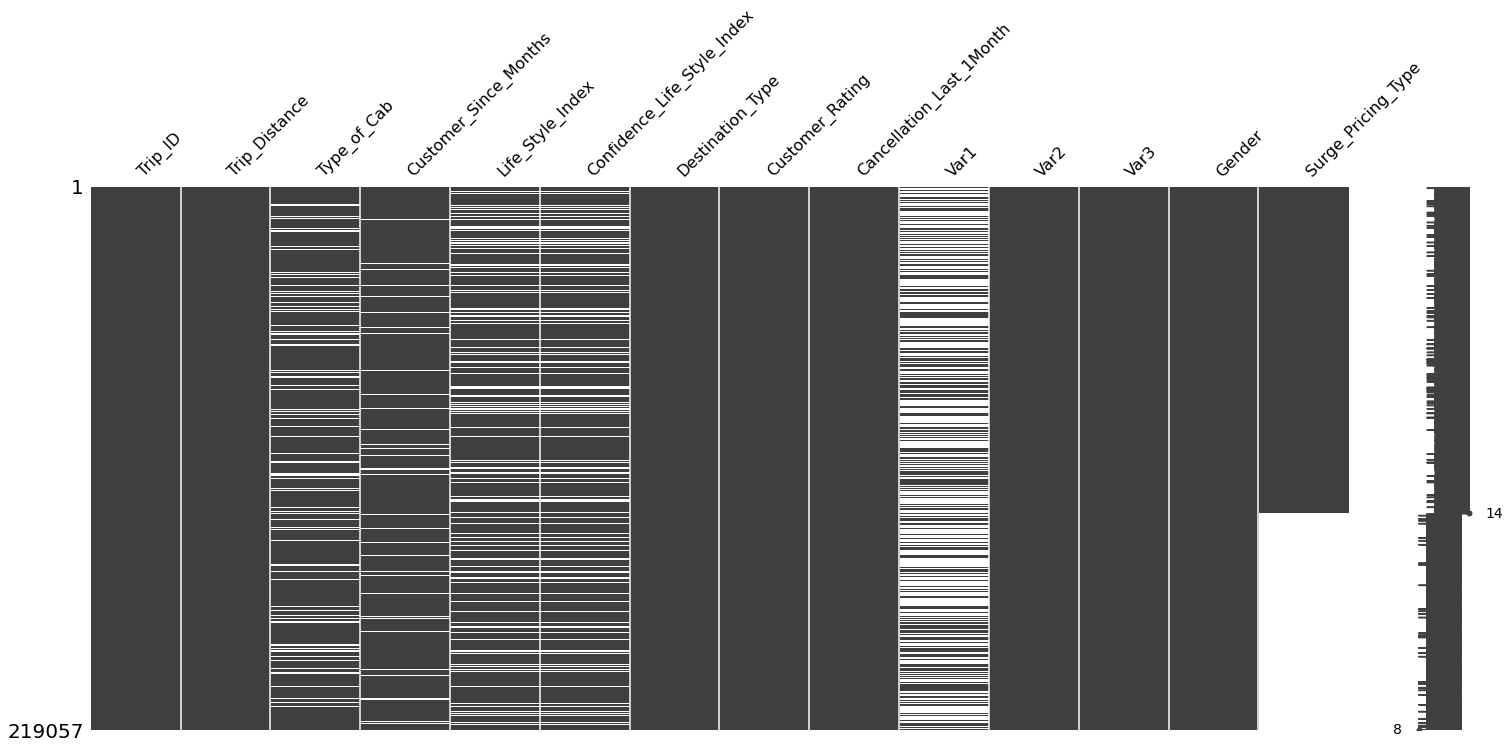

In [7]:
missingno.matrix(comb)

In [8]:
#Checking for any duplicate data
if len(comb[comb.duplicated()]) > 0:
    print("No. of duplicated entries: ", len(comb[comb.duplicated()]))
    print(comb[comb.duplicated(keep=False)].sort_values(by=list(comb.columns)).head())
else:
    print("No duplicated entries found")

No duplicated entries found


## Working on numerical data

In [9]:
comb.describe()

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3
count,219057.000000,209171.000000,185537.000000,219057.000000,219057.000000,101238.000000,219057.000000,219057.000000
mean,44.158725,6.006048,2.802594,2.848632,0.782915,64.095972,51.186586,75.065777
std,25.507368,3.626891,0.226323,0.981100,1.036244,21.747037,4.974497,11.580112
min,0.310000,0.000000,1.317850,0.001250,0.000000,30.000000,40.000000,52.000000
25%,24.560000,3.000000,2.654620,2.152500,0.000000,46.000000,48.000000,67.000000
50%,38.140000,6.000000,2.798280,2.895000,0.000000,61.000000,50.000000,74.000000
75%,60.720000,10.000000,2.947650,3.581250,1.000000,79.000000,54.000000,82.000000
max,109.230000,10.000000,4.875110,5.000000,8.000000,210.000000,124.000000,206.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f76b07319d0>,
      dtype=object)

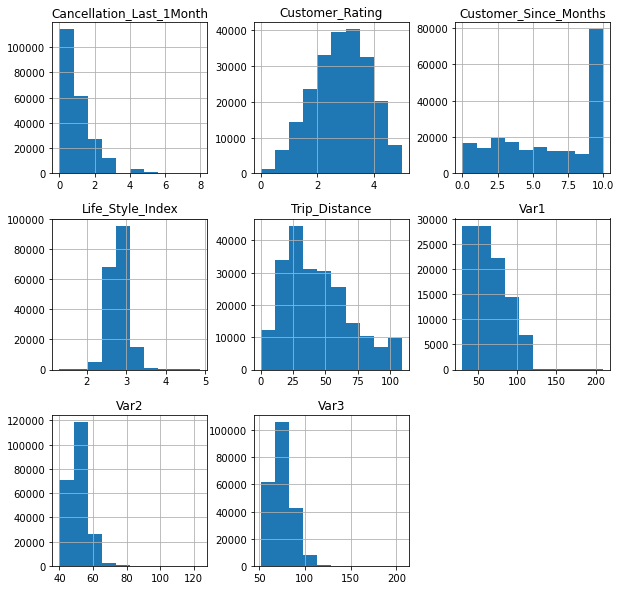

In [10]:
comb.hist(figsize=(10,10))

**We can see there is a big variance in the values of some of the features(difference in min and max values),lets apply log transformation on them**

In [11]:
col_log =['Trip_Distance','Var1','Var2','Var3']
comb[col_log]=np.log(comb[col_log])

***Imputing values using MICE(Multivariate Imputation by Chained Equation)***

In [12]:
pip install impyute


You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [13]:
col = ['Customer_Since_Months','Life_Style_Index','Var1']

In [14]:
from impyute.imputation.cs import mice

X = comb[col]

imputed = mice(X.values,verbose=1)

#mice_ages = imputed[:, 2]

In [15]:
imputed.shape

(219057, 3)

In [16]:
mice_csm = imputed[:, 0]
mice_lsi = imputed[:, 1]
mice_var1 = imputed[:, 2]

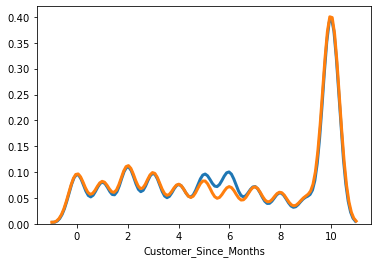

In [17]:
sns.distplot(mice_csm, hist = False, kde = True,
                 kde_kws = {'shade': False, 'linewidth': 3})
sns.distplot(comb['Customer_Since_Months'], hist = False, kde = True,
                 kde_kws = {'shade': False, 'linewidth': 3})

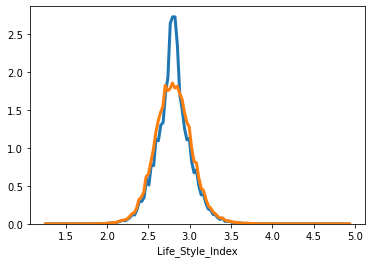

In [18]:
sns.distplot(mice_lsi, hist = False, kde = True,
                 kde_kws = {'shade': False, 'linewidth': 3})
sns.distplot(comb['Life_Style_Index'], hist = False, kde = True,
                 kde_kws = {'shade': False, 'linewidth': 3})

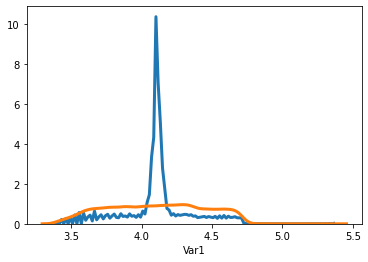

In [19]:
sns.distplot(mice_var1, hist = False, kde = True,
                 kde_kws = {'shade': False, 'linewidth': 3})
sns.distplot(comb['Var1'], hist = False, kde = True,
                 kde_kws = {'shade': False, 'linewidth': 3})



> As you can see in above plots, the variance in distribution of data after imputing is done is not very large.This is the reason this method is preferred over imputing by other test statistics.



In [20]:
comb['Customer_Since_Months'] = mice_csm
comb['Life_Style_Index'] = mice_lsi
comb['Var1'] = mice_var1

In [21]:
comb.isnull().sum()

Trip_ID                            0
Trip_Distance                      0
Type_of_Cab                    33368
Customer_Since_Months              0
Life_Style_Index                   0
Confidence_Life_Style_Index    33520
Destination_Type                   0
Customer_Rating                    0
Cancellation_Last_1Month           0
Var1                               0
Var2                               0
Var3                               0
Gender                             0
Surge_Pricing_Type             87395
dtype: int64

## Working with categorical features

**We will start by imputing values in features having Null values.For this we will create a separate category 'Unknown' as the number of unknowns is greater than number of observations in some other categories and filling it with some test statistics may cause biasing.**

In [22]:
comb['Type_of_Cab'] = comb['Type_of_Cab'].cat.add_categories('Unknown')
comb['Type_of_Cab'].fillna("Unknown", inplace=True)

In [23]:
comb['Confidence_Life_Style_Index'] = comb['Confidence_Life_Style_Index'].cat.add_categories('Unknown')
comb['Confidence_Life_Style_Index'].fillna("Unknown", inplace=True)

In [24]:
cat_col = ['Type_of_Cab','Confidence_Life_Style_Index','Destination_Type','Gender','Surge_Pricing_Type']
for i in cat_col:
  print("=================")
  print(comb[i].value_counts())

B          51585
C          46732
A          35878
Unknown    33368
D          31885
E          19609
Name: Type_of_Cab, dtype: int64
B          67265
C          59736
A          58536
Unknown    33520
Name: Confidence_Life_Style_Index, dtype: int64
A    129010
B     49193
C     12397
D     11085
E      4549
F      3222
G      2513
H      2124
I      1334
J      1166
K      1102
L      1052
M       160
N       150
Name: Destination_Type, dtype: int64
Male      156128
Female     62929
Name: Gender, dtype: int64
2.0    56728
3.0    47720
1.0    27214
Name: Surge_Pricing_Type, dtype: int64


**We can see there are a lot of categories in destination type.This will lead to many extra columns after one-hot encoding which may impact our model accuracy**

*We will try to minimize the categories by making bins ['High_vol','Med_Vol','Low_Vol'] based on the volumes*

In [25]:
comb['Destination_Type'].replace({"A":1,"B":2,"C":3,"D":4,"E":5,"F":6,"G":7,"H":8,"I":9,"J":10,"K":11,"L":12,"M":13,"N":14},inplace = True)
comb['Destination_Type']

0         1
1         1
2         5
3         1
4         1
         ..
87390     1
87391     4
87392     1
87393    10
87394     1
Name: Destination_Type, Length: 219057, dtype: int64

In [26]:
bins= [1,4,12,14]
labels = ['High_vol','Med_vol','Low_vol']
comb['Destination_Type'] = pd.cut(comb['Destination_Type'], bins=bins, labels=labels, right=False)


In [27]:
comb['Destination_Type'].value_counts()

High_vol    190600
Med_vol      27095
Low_vol       1212
Name: Destination_Type, dtype: int64

In [28]:
comb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219057 entries, 0 to 87394
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   Trip_ID                      219057 non-null  object  
 1   Trip_Distance                219057 non-null  float64 
 2   Type_of_Cab                  219057 non-null  category
 3   Customer_Since_Months        219057 non-null  float64 
 4   Life_Style_Index             219057 non-null  float64 
 5   Confidence_Life_Style_Index  219057 non-null  category
 6   Destination_Type             218907 non-null  category
 7   Customer_Rating              219057 non-null  float64 
 8   Cancellation_Last_1Month     219057 non-null  int64   
 9   Var1                         219057 non-null  float64 
 10  Var2                         219057 non-null  float64 
 11  Var3                         219057 non-null  float64 
 12  Gender                       219057 non-null 

**Time for One-Hot Encoding**

In [29]:
dummies_toc = pd.get_dummies(comb['Type_of_Cab'],prefix='toc',prefix_sep='_')
dummies_clsi = pd.get_dummies(comb['Confidence_Life_Style_Index'],prefix = 'clsi',prefix_sep='_')

In [30]:
dummies_dt = pd.get_dummies(comb['Destination_Type'])
dummies_gender = pd.get_dummies(comb['Gender'])

In [31]:
merged = pd.concat([comb,dummies_toc,dummies_clsi,dummies_dt,dummies_gender],axis = 'columns')
comb = merged.drop(['Type_of_Cab','Confidence_Life_Style_Index','Destination_Type','Gender'],axis = 'columns')

comb.shape

(219057, 25)

**This is how our final data looks. Data looks pretty normalized so we will not be performing nirmalization separately**

In [32]:
comb.head()

,Trip_ID,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Surge_Pricing_Type,...,toc_Unknown,clsi_A,clsi_B,clsi_C,clsi_Unknown,High_vol,Med_vol,Low_vol,Female,Male
0,T0005689460,1.912501,1.0,2.427690,3.90500,0,3.688879,3.828641,4.094345,2.0,...,0,1,0,0,0,1,0,0,1,0
1,T0005689461,3.383373,10.0,2.782450,3.45000,0,3.637586,4.025352,4.356709,2.0,...,0,0,1,0,0,1,0,0,0,1
2,T0005689464,3.727619,10.0,2.838182,3.50125,2,4.104003,4.025352,4.343805,2.0,...,1,0,0,0,1,0,1,0,0,1
3,T0005689465,4.120012,10.0,2.838182,3.45375,0,4.104003,3.951244,4.304065,3.0,...,0,0,0,0,1,1,0,0,0,1
4,T0005689467,4.006424,10.0,3.034530,3.40250,4,3.931826,3.891820,4.624973,2.0,...,0,0,1,0,0,1,0,0,0,1


In [33]:
train_features = comb[comb['Surge_Pricing_Type'].isnull()!=True].drop(['Trip_ID','Surge_Pricing_Type'], axis=1)
train_label = comb[comb['Surge_Pricing_Type'].isnull()!=True]['Surge_Pricing_Type']

test_features = comb[comb['Surge_Pricing_Type'].isnull()==True].drop(['Trip_ID','Surge_Pricing_Type'], axis=1)

train_features.shape,train_label.shape,test_features.shape


((131662, 23), (131662,), (87395, 23))

# Model Training

In [34]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(train_features, train_label, test_size=0.25,random_state=42,stratify = train_label)

In [35]:
train = x_train.append(x_val)
val = y_train.append(y_val)



> The approach for this problem will be to choose some models which will provide stable and good accuracies and finally apply hard voting on these to get the results

**Following models have been chosen for this purpose:**

*   XGBoost
*   Light Gradient Boost
*   Multi Layer Perceptron











In [36]:
#xgboost
from xgboost import XGBClassifier
xgb = XGBClassifier(base_score=0.6,learning_rate=0.05,objective='multi:softmax',n_estimators=300,max_depth=8,n_jobs=-1)
xgb.fit(x_train,y_train)

XGBClassifier(base_score=0.6, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [37]:
print(xgb.score(x_val,y_val))

0.6976242556811277


In [38]:
# light gradient boost
from lightgbm import LGBMClassifier

lgbc=LGBMClassifier(n_estimators=425, learning_rate=0.08,objective= 'multiclass', reg_lambda=3,max_depth=8,min_child_weight=0.1)
lgbc.fit(x_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.08, max_depth=8,
               min_child_samples=20, min_child_weight=0.1, min_split_gain=0.0,
               n_estimators=425, n_jobs=-1, num_leaves=31,
               objective='multiclass', random_state=None, reg_alpha=0.0,
               reg_lambda=3, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [39]:
lgbc.score(x_val,y_val)

0.6997812613926357

In [40]:
#best parameter selection for Perceptron
from sklearn.model_selection import GridSearchCV


mlp = MLPClassifier(max_iter=100)
parameter_space = {
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.001, 0.01,0.1],
    'learning_rate': ['constant','adaptive'],
}
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(x_train, y_train)

print('Best parameters found:\n', clf.best_params_)


NameError: name 'MLPClassifier' is not defined

In [41]:
from sklearn.neural_network import MLPClassifier
p = MLPClassifier(random_state=42,
              max_iter=200,activation='relu',solver ='adam',learning_rate='adaptive')
p.fit(x_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [42]:
p.score(x_val,y_val)

0.6947381212784056

*Fitting our models to entire dataset*

In [43]:
xgb.fit(train,val)
lgbc.fit(train,val)
p.fit(train,val)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

**Hard-Voting Ensemble**

***In hard voting (also known as majority voting), every individual classifier votes for a class, and the majority wins. In statistical terms, the predicted target label of the ensemble is the mode of the distribution of individually predicted labels.***

In [44]:
from sklearn.ensemble import VotingClassifier
estimator = []
estimator.append(('MLP', p))
estimator.append(('XGB', xgb )) 
estimator.append(('LGBM', lgbc)) 
 
  
# Voting Classifier with hard voting 
vot_hard = VotingClassifier(estimators = estimator, voting ='hard') 
vot_hard.fit(train, val) 

VotingClassifier(estimators=[('MLP',
                              MLPClassifier(activation='relu', alpha=0.0001,
                                            batch_size='auto', beta_1=0.9,
                                            beta_2=0.999, early_stopping=False,
                                            epsilon=1e-08,
                                            hidden_layer_sizes=(100,),
                                            learning_rate='adaptive',
                                            learning_rate_init=0.001,
                                            max_fun=15000, max_iter=200,
                                            momentum=0.9, n_iter_no_change=10,
                                            nesterovs_momentum=True,
                                            power_t=0.5, random_state=42,
                                            shuf...
                                             importance_type='split',
                                            

In [45]:
print(vot_hard.score(x_val,y_val))

0.7267894033296877




> The model performs quite well on the validation dataset. Let us now use it for predictions on test dataset.








# Making Predictions

In [46]:
pred_vot_hard = vot_hard.predict(test_features)
unique_elements, counts_elements = np.unique(pred_vot_hard, return_counts=True)
print(unique_elements,counts_elements)

[1. 2. 3.] [13230 44195 29970]


In [47]:
pd.DataFrame(pred_vot_hard, columns=['Surge_Pricing_Type']).to_csv('/prediction_vot_final.csv')

**The final score recieved on the scoreboard was 0.7012.It is a general agreement that ensembles are more stable and accurate than stand-alone models**

# Conclusion



*In this notebook we successfully predicted the Surge_Pricing_Type for cab aggregators.*

**Some important concepts learned:**

*   MICE helps in imputation of missing data for numerical features with minimal effect on variance of the distribution.
*   If number of NaN's are very large(larger than observations in one of the category) it is better to make a separate category out of them.


*   To remove skewness/outliers in features we can apply log transformation or normalization.
*   Building an ensemble is an effective way to get a stable model.





